# GA Analytics
## Feature Engineering, Pre-processing, and Modelling
### Blaine Murphy -- September 2021


For the feature engineering phase I will do the following.
- Read in the data exported from the EDA notebook
- Encode categorical features identified in EDA
- Condense data to user level
    - to help answer the business question for identifying big spenders and how to market to them
    - compute the target -- ln(total_user_revenue+1)
    - Calculate user level features with summary statistics for numeric features
- Split data into train, validation, and test for modelling
- Scale the data based on the training data
- Export data sets prepped for modelling

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')
os.listdir()

['e390021b-3cdc-4df0-b92e-22082e3ad15b_Data.csv',
 'GA_features.csv',
 'GA_Test.npz',
 'GA_Train.npz',
 'GA_Validation.npz',
 'GDP by Country world bank.csv',
 'life expectency by country_world bank.csv',
 'Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Country_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'Metadata_Indicator_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Indicator_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'model.png',
 'Population by country world bank.csv',
 'sample_submission.csv',
 'sample_submission_v2.csv',
 'test.csv',
 'test_v2.csv',
 'train.csv',
 'train_eda.csv',
 'train_v2.csv',
 'train_wrangled.csv',
 'user_train_X.csv',
 'user_train_y.csv',
 'worldpopulationreview.com']

In [3]:
train = pd.read_csv('train_eda.csv',index_col=0,parse_dates=['date','dateTime'])
train.info()

C:\Users\blain\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 50 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

A couple of columns to fix. `keyword` is mostly null and I already created new columns from it based on the most frequent search words that resulted in a purchase.  I can drop it now.  

And `timeDiffLastVisit` is mostly null because most of the records are new visits, not repeat visits.  I will fill all of those nulls with the maximum of the `timeDiffLastVisit` column.


In [4]:
train.drop('keyword',axis=1,inplace=True)
train['timeDiffLastVisit'] = train.timeDiffLastVisit.fillna(train.timeDiffLastVisit.max())


In [5]:
### Convert to float for summary statistics below
train['hits'] = train['hits'].astype('float')
train['pageviews'] = train['pageviews'].astype('float')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 49 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

In [7]:
window_start = train['visitStartTime'].min()
window_end = train['visitStartTime'].max()

### One hot encoding of categorical columns

In [8]:
"','".join(list(train.columns))

"channelGrouping','date','fullVisitorId','sessionId','visitId','visitNumber','visitStartTime','browser','operatingSystem','isMobile','deviceCategory','continent','subContinent','country','region','metro','city','campaign','source','hits','pageviews','bounces','newVisits','transactionRevenue','dollars','purchase','dateTime','hour','weekend','month','time','timeDiffLastVisit','countryPopulation','countryGDP','countryLE','state','keywordStore','keywordMerch','keywordShirt','keywordGoogle','keywordYoutube','keywordShop','keywordApparel','keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)','keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search"

In [9]:
num_cols = ['fullVisitorId','visitNumber','isMobile','hits','pageviews','bounces','newVisits',\
        'visitStartTime','weekend','time','timeDiffLastVisit',\
        'countryPopulation','countryGDP','countryLE','keywordStore',\
        'keywordMerch','keywordShirt','keywordGoogle',\
        'keywordYoutube','keywordShop','keywordApparel',\
        'keyword_(Remarketing/Content targeting)',\
        'keyword_(User vertical targeting)','keyword_(automatic matching)',\
        'keyword_(content targeting)','keyword_(not provided)','keyword_search',\
        'dollars','transactionRevenue']

In [10]:
dummy_cols = ['channelGrouping','browser','operatingSystem',\
              'deviceCategory','subContinent','city','state',\
              'campaign','source','month','hour']

In [11]:
### convert month to object for label encoding, ditto for hour
train['month'] = train['month'].astype('object')
train['month'].dtype

train['hour'] = train['hour'].astype('object')


In [12]:
train = pd.concat([train[num_cols],pd.get_dummies(train[dummy_cols])], axis=1)

In [13]:
train.shape

(901907, 343)

In [14]:
train_cols = list(train.columns)

### Grouping by user

In [15]:
bool_cols = ['isMobile','weekend','bounces','keywordStore','keywordMerch','keywordShirt',\
             'keywordGoogle','keywordYoutube','keywordShop','keywordApparel',\
             'keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)',\
             'keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search' ]

In [16]:
user_groupby = train.groupby('fullVisitorId', as_index=True)

Creation of target in a new user level dataframe

In [17]:
### Function for creation of target column ln(total_revenue_per_user + 1)
TargetFunc = lambda x: np.log(sum(x) + 1.0)

### Calculate target
X = user_groupby[['transactionRevenue']].agg(TargetFunc)


In [18]:
### Create features based on visits
X['visits'] = user_groupby[['transactionRevenue']].count()
X['visitMax'] = user_groupby['visitNumber'].max()
X['visitMin'] = user_groupby['visitNumber'].min()

### Create features based on time between visits and start and end of the data window
X['timeTilFirstVisit'] = user_groupby['visitStartTime'].agg(lambda x: min(x) - window_start)
X['timeLastVisitFromEnd'] = user_groupby['visitStartTime'].agg(lambda x: window_end - max(x))



### Create statistical measures of numerical columns
for col in ['hits','pageviews','timeDiffLastVisit']:
    dum = user_groupby[[col]].agg(['min','max','median','mean','std'])
    dum.columns = [col+i.capitalize() for i in ['min','max','median','mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum

    
for col in ['countryPopulation','countryGDP','countryLE']:
    dum = user_groupby[[col]].agg(['mean','std'])
    dum.columns = [col+i.capitalize() for i in ['mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum
    
### calculate mean of boolean columns
for col in bool_cols:
    dum = user_groupby[[col]].mean()
    dum.columns = [col+'Mean']
    X = pd.concat([X,dum], axis=1)
    del dum

### Mean of dummy columns with correct column naming
for col in dummy_cols:
    for dumi_col in [i for i in train_cols if i.startswith(col)]:
        dum = user_groupby[[dumi_col]].mean()
        dum.columns = [dumi_col+'Mean']
        X = pd.concat([X,dum], axis=1)
        del dum



    
X.head()

,transactionRevenue,visits,visitMax,visitMin,timeTilFirstVisit,timeLastVisitFromEnd,hitsMin,hitsMax,hitsMedian,hitsMean,...,hour_14Mean,hour_15Mean,hour_16Mean,hour_17Mean,hour_18Mean,hour_19Mean,hour_20Mean,hour_21Mean,hour_22Mean,hour_23Mean
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
4823595352351,0.0,1,1,1,7976698,23645683,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5103959234087,0.0,1,1,1,1782396,29839985,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10278554503158,0.0,1,1,1,6994654,24627727,11.0,11.0,11.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20424342248747,0.0,1,1,1,10544089,21078292,17.0,17.0,17.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26722803385797,0.0,1,1,1,26623582,4998799,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_cols = X.columns

In [20]:
nulls = X.isna().sum().T
nulls[nulls>0]

hitsStd                 631804
pageviewsStd            631804
timeDiffLastVisitStd    631804
countryPopulationStd    631804
countryGDPStd           631804
countryLEStd            631804
dtype: int64

In [21]:
X = X.fillna(0)

In [22]:
del train

In [23]:
y = X.pop('transactionRevenue')

In [24]:
X.shape

(722668, 356)

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    dropped=[]
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        
        ### Create data frame with features column and 
        ### variance inflation factor column
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        
        
        if vif['VIFactor'].max() > vif_threshold:
            dropped.append(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0])
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
            #if count==45:
                #print('early stop for plotting intermediate step')
                #return df, vif.sort_values('VIFactor')  
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

In [ ]:
#Running list of columns to pop from vif
#cols2pop = "pageviewsMean,timeDiffLastVisitMin,channelGrouping_DirectMean,hitsMin,\
#            deviceCategory_desktopMean,isMobileMean,operatingSystem_WindowsMean,keyword_searchMean,\
#            campaign_Data Share PromoMean,browser_ChromeMean,channelGrouping_Organic SearchMean,\
#            '

In [28]:
### Use only a fraction of the total set for calculating vif
frac_for_vif=0.5
final_X, final_vif = iterate_vif(X.sample(frac=frac_for_vif), vif_threshold = 2)
del frac_for_vif

Iteration # 1


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMean with VIF of 12866.558853
Iteration # 2


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeDiffLastVisitMin with VIF of 5140.597565
Iteration # 3


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_DirectMean with VIF of 3095.226798
Iteration # 4


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsMin with VIF of 1413.460876
Iteration # 5


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing deviceCategory_desktopMean with VIF of 2240.571371
Iteration # 6


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing isMobileMean with VIF of 1558.188844
Iteration # 7


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing operatingSystem_WindowsMean with VIF of 1254.257758
Iteration # 8


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing keyword_searchMean with VIF of 966.199870
Iteration # 9


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing campaign_Data Share PromoMean with VIF of 1127.683490
Iteration # 10


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing browser_ChromeMean with VIF of 1030.678377
Iteration # 11


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_Organic SearchMean with VIF of 1126.695030
Iteration # 12


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing month_2Mean with VIF of 568.216257
Iteration # 13


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing source_PartnersMean with VIF of 739.503303
Iteration # 14


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsMean with VIF of 475.792441
Iteration # 15


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMax with VIF of 361.411058
Iteration # 16


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_SocialMean with VIF of 335.590121
Iteration # 17


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hour_23Mean with VIF of 225.407011
Iteration # 18


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeDiffLastVisitMean with VIF of 172.818357
Iteration # 19


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing subContinent_Northern AmericaMean with VIF of 185.849077
Iteration # 20


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_New YorkMean with VIF of 148.737577
Iteration # 21


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_CaliforniaMean with VIF of 122.508338
Iteration # 22


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing source_googleMean with VIF of 106.420462
Iteration # 23


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMedian with VIF of 95.096359
Iteration # 24


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_not availableMean with VIF of 79.340176
Iteration # 25


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeLastVisitFromEnd with VIF of 60.439528
Iteration # 26


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing deviceCategory_mobileMean with VIF of 59.076608
Iteration # 27


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsStd with VIF of 46.110162
Iteration # 28


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing campaign_(not set)Mean with VIF of 56.996874
Iteration # 29


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_PennsylvaniaMean with VIF of 85.900100
Iteration # 30


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_WashingtonMean with VIF of 48.048850
Iteration # 31


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_NotUSMean with VIF of 53.949551
Iteration # 32


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_Paid SearchMean with VIF of 39.551551
Iteration # 33


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_IllinoisMean with VIF of 39.550525
Iteration # 34


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing keyword_(not provided)Mean with VIF of 30.966933
Iteration # 35


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_TexasMean with VIF of 27.744797
Iteration # 36


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_ColoradoMean with VIF of 22.654781
Iteration # 37


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_MassachusettsMean with VIF of 20.316989
Iteration # 38


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_GeorgiaMean with VIF of 26.676573
Iteration # 39


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeTilFirstVisit with VIF of 20.116646
Iteration # 40


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing visitMax with VIF of 18.657920
Iteration # 41


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_ReferralMean with VIF of 17.918270
Iteration # 42


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMin with VIF of 17.262476
Iteration # 43


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing countryGDPMean with VIF of 15.127709
Iteration # 44


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_IowaMean with VIF of 427.925690
Iteration # 45


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_IndianaMean with VIF of 317.242007
Iteration # 46


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_NebraskaMean with VIF of 270.990317
Iteration # 47


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_ArizonaMean with VIF of 84.150813
Iteration # 48


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_OhioMean with VIF of 14.144609
Iteration # 49


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsMax with VIF of 12.992709
Iteration # 50


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_North CarolinaMean with VIF of 12.900601
Iteration # 51


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_MichiganMean with VIF of 9.593952
Iteration # 52


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_TennesseeMean with VIF of 8.328811
Iteration # 53


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_MinneapolisMean with VIF of 7.263147
Iteration # 54


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_DisplayMean with VIF of 7.174712
Iteration # 55


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeDiffLastVisitMedian with VIF of 7.033057
Iteration # 56


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing countryPopulationMean with VIF of 5.098741
Iteration # 57


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_South CarolinaMean with VIF of 4.847291
Iteration # 58


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing operatingSystem_iOSMean with VIF of 3.385674
Iteration # 59


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing keywordGoogleMean with VIF of 3.338812
Iteration # 60


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_Kansas CityMean with VIF of 3.331553
Iteration # 61


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing month_11Mean with VIF of 2.769966
Iteration # 62


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_FloridaMean with VIF of 2.624802
Iteration # 63


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing campaign_AW - AccessoriesMean with VIF of 2.346881
Iteration # 64


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_HamdenMean with VIF of 2.330851
Iteration # 65


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hour_17Mean with VIF of 2.314031
Iteration # 66


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing countryLEStd with VIF of 2.240670
Iteration # 67


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing subContinent_AustralasiaMean with VIF of 2.134498
Iteration # 68


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing subContinent_Southeast AsiaMean with VIF of 2.090557
Iteration # 69


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Complete


In [33]:
final_features = list(final_X.columns)

In [34]:
X = X[final_features]

In [35]:
X.shape

(722668, 288)

Now splitting into train and test sets

In [36]:
random_seed = 33

In [37]:
### Split into 70-20-10 train-validation-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.333, random_state=random_seed)


In [38]:
print('Train features:', X_train.shape)
print('Train target:', y_train.shape)
print('Validation features:',X_val.shape)
print('Validation target:',y_val.shape)
print('Test features:',X_test.shape)
print('Test target:',y_test.shape)


Train features: (505867, 288)
Train target: (505867,)
Validation features: (144606, 288)
Validation target: (144606,)
Test features: (72195, 288)
Test target: (72195,)


In [39]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train, X_test, X_val = ss.transform(X_train), ss.transform(X_test), ss.transform(X_val)




In [40]:
np.savez('GA_Train', inputs=X_train, targets = y_train)
np.savez('GA_Validation', inputs=X_val, targets = y_val)
np.savez('GA_Test', inputs=X_test, targets = y_test)

In [41]:
with open('GA_features.csv','w') as f:
    [f.write(col+'\n') for col in X_final_features]

    

Data saved.

In [42]:
print('Train Frac of purchasers:', np.sum(y_train > 1) / y_train.shape[0])
print('Validation Frac purchasers:', np.sum(y_val > 1) / y_val.shape[0])
print('Test Frac purchasers:', np.sum(y_test > 1) / y_test.shape[0])

Train Frac of purchasers: 0.014132173081066762
Validation Frac purchasers: 0.013747700648659116
Test Frac purchasers: 0.013865226123692776


## Modelling phase

### Linear Regression with Lasso to get a baseline model performance and quick look at feature importance

In [1]:
import pandas as pd
import numpy as np
import os 

os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')

In [2]:
### Loading data
train = np.load('GA_Train.npz')
valid = np.load('GA_Validation.npz')
test = np.load('GA_Test.npz')


In [3]:
from sklearn.linear_model import Lasso
lass = Lasso()
lass.fit(train['inputs'], train['targets'])

Lasso()

In [4]:
from sklearn.metrics import mean_squared_error
print('Lasso Regression RMSE:\n{:.3f}'.format(np.sqrt(mean_squared_error(valid['targets'],lass.predict(valid['inputs'])))))


Lasso Regression RMSE:
2.078


In [5]:
print(lass.coef_)

[ 0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0. -0.  0.  0.
 -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0.
 -0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0.  0.
  0. -0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0. -0. -0. -0.
  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0.
 -0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.
  0. -0. -0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0. -0.  0.  0.  0. -0.
 -0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0. -0.  0.  0.  0. -0.
  0.  0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0. -0. -0.  0. -0. -0.
  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.
 -0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0.  0

Due to the large number of users who didn't make a purchaes The model predicts nobody will make a purchase.  

### Moving on to deep learning with TensorFlow

In [6]:
import tensorflow as tf


In [7]:
train_num_purchasers = np.sum(train['targets'] > 1) 

#train['targets'].shape[0] / train_num_purchasers

print('There should be a purchase every {:.0f} records'.format(train['targets'].shape[0] / train_num_purchasers))


There should be a purchase every 71 records


In the training set I would expect to see one purchase every 71 records. I will try a batch size of 500 to try to get multiple purchases in each batch

In [8]:
### Declare some variables for modelling 

input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


Model building

In [9]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 3s - loss: 3.2735 - root_mean_squared_error: 1.8093 - mean_absolute_error: 0.4369 - val_loss: 2.7681 - val_root_mean_squared_error: 1.6638 - val_mean_absolute_error: 0.3628
Epoch 2/50
1012/1012 - 3s - loss: 2.9332 - root_mean_squared_error: 1.7127 - mean_absolute_error: 0.3656 - val_loss: 2.7506 - val_root_mean_squared_error: 1.6585 - val_mean_absolute_error: 0.3437
Epoch 3/50
1012/1012 - 4s - loss: 2.8458 - root_mean_squared_error: 1.6869 - mean_absolute_error: 0.3519 - val_loss: 2.7574 - val_root_mean_squared_error: 1.6605 - val_mean_absolute_error: 0.3354
Epoch 4/50
1012/1012 - 3s - loss: 2.8001 - root_mean_squared_error: 1.6734 - mean_absolute_error: 0.3446 - val_loss: 2.6890 - val_root_mean_squared_error: 1.6398 - val_mean_absolute_error: 0.3036
Epoch 5/50
1012/1012 - 3s - loss: 2.7501 - root_mean_squared_error: 1.6583 - mean_absolute_error: 0.3387 - val_loss: 2.7267 - val_root_mean_squared_error: 1.6513 - val_mean_absolute_error: 0.3449
Epoch 6/50
1012/1012

In [11]:
import matplotlib.pyplot as plt
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    

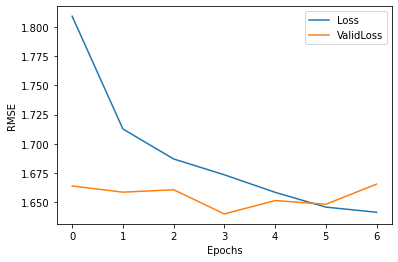

In [12]:
PlotLoss(history)

In [13]:
model.metrics_names

['loss', 'root_mean_squared_error', 'mean_absolute_error']

In [14]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
base_seq_nn = pd.DataFrame(perf,index = ['train','validation','test'])
base_seq_nn

2257/2257 [==============================] - 2s 705us/step - loss: 2.7643 - root_mean_squared_error: 1.6626 - mean_absolute_error: 0.3063


,RMSE
train,1.630484
validation,1.639824
test,1.662625


The test RMSE is higher than the validation RMSE suggesting that this model is overfitting to the train and validation sets.  Now visualizing the model predictions.

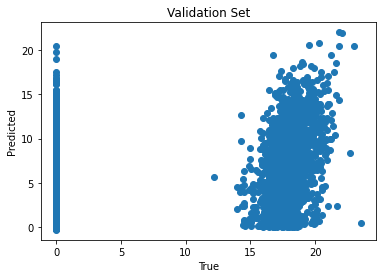

In [15]:
plt.scatter(valid['targets'],model.predict(valid['inputs']))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation Set')
plt.show()

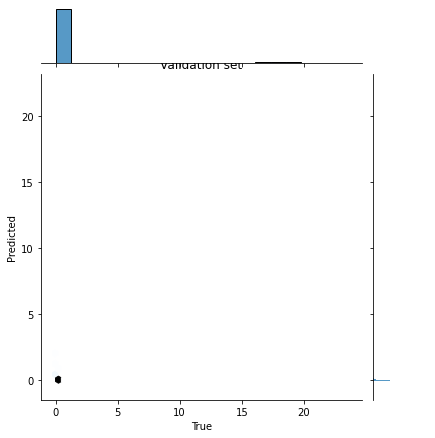

In [16]:
import seaborn as sns
sns.jointplot(x=valid['targets'],y=model.predict(valid['inputs']).reshape(-1), kind='hex')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation set')
plt.show()

It is hard to see the model predictions due to the very large numbers of ~0-0 true-predictions.  I will null these out and see if what the predictions look like.

In [17]:
mask = (valid['targets']<1.0) & (model.predict(valid['inputs']).reshape(-1)<1.0)
print(sum(mask))

138361


In [18]:
valid_target_masked = np.copy(valid['targets'])
valid_target_masked[mask==True] = np.NAN

valid_predicted_masked = np.copy(model.predict(valid['inputs']).reshape(-1))
valid_predicted_masked[mask==True] = np.NAN

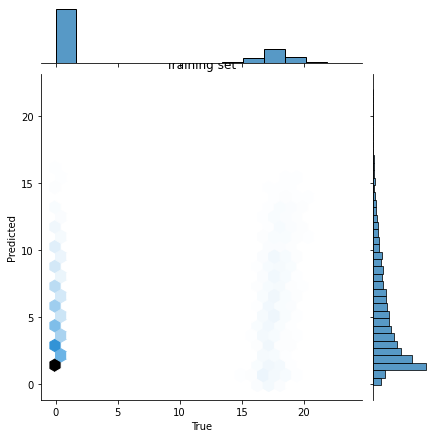

In [19]:
import seaborn as sns
sns.jointplot(x=valid_target_masked , y=valid_predicted_masked, dropna=True, kind='hex')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training set')
plt.show()

Not great. The 3 layer NN does not do a great job of predicting user revenue.  As shown before, only about 1% of the users made a purchase, and I believe this imbalance could be what's causing the poor results.  
___
## NN Classifier for purchase
Now I will try to create a NN model that predicts only whether a purchase was made. If that is succesful it could be an input into the regression model.  



In [20]:
train_purchase = 1.0 * np.array( [train['targets'] == 0, train['targets']>0] ).T
valid_purchase = 1.0 * np.array( [valid['targets'] ==0 , valid['targets'] > 0] ).T
test_purchase = 1.0 * np.array( [test['targets'] ==0 , test['targets'] > 0] ).T

In [21]:
### 
input_size = train['inputs'].shape[1]
output_size = 2
hidden_layer_size = 64
batch_size = 500
epochs = 50

In [22]:
clf_model = tf.keras.Sequential()
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dropout(.2))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dense(output_size,activation='softmax'))

clf_model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])




In [23]:
stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = clf_model.fit(train['inputs'],train_purchase,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        callbacks=stop,                    
                        validation_data=(valid['inputs'],valid_purchase),
                        verbose=2
                       )                    

Epoch 1/50
1012/1012 - 4s - loss: 0.0495 - auc: 0.9963 - precision: 0.9828 - recall: 0.9828 - val_loss: 0.0318 - val_auc: 0.9984 - val_precision: 0.9876 - val_recall: 0.9876
Epoch 2/50
1012/1012 - 3s - loss: 0.0321 - auc: 0.9980 - precision: 0.9872 - recall: 0.9872 - val_loss: 0.0303 - val_auc: 0.9979 - val_precision: 0.9880 - val_recall: 0.9880
Epoch 3/50
1012/1012 - 4s - loss: 0.0306 - auc: 0.9981 - precision: 0.9874 - recall: 0.9874 - val_loss: 0.0297 - val_auc: 0.9983 - val_precision: 0.9881 - val_recall: 0.9881
Epoch 4/50
1012/1012 - 4s - loss: 0.0297 - auc: 0.9982 - precision: 0.9877 - recall: 0.9877 - val_loss: 0.0295 - val_auc: 0.9984 - val_precision: 0.9882 - val_recall: 0.9882
Epoch 5/50
1012/1012 - 4s - loss: 0.0291 - auc: 0.9983 - precision: 0.9877 - recall: 0.9877 - val_loss: 0.0296 - val_auc: 0.9987 - val_precision: 0.9881 - val_recall: 0.9881
Epoch 6/50
1012/1012 - 4s - loss: 0.0289 - auc: 0.9984 - precision: 0.9878 - recall: 0.9878 - val_loss: 0.0299 - val_auc: 0.9984 -

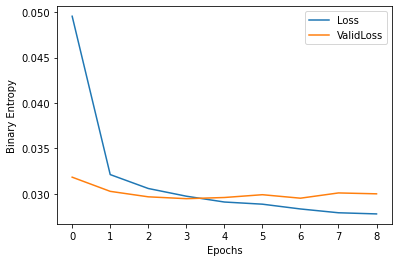

In [24]:
def PlotClfLoss(hist):
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Entropy')
    plt.legend()
    plt.show()
    
PlotClfLoss(history)

In [25]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix
train_predict_proba = clf_model.predict(train['inputs'])[:,1]
valid_predict_proba = clf_model.predict(valid['inputs'])[:,1]
test_predict_proba = clf_model.predict(test['inputs'])[:,1]

train_predicts = 1 * (train_predict_proba > 0.1)
valid_predicts = 1 * (valid_predict_proba > 0.1)

print('Train ROC AUC:', roc_auc_score(train_predicts ,train_predict_proba ))
print('Train Recall:',recall_score(train_purchase[:,1], train_predicts))
print('Train Precision:',precision_score(train_purchase[:,1], train_predicts))
print()
print('Validation ROC AUC:', roc_auc_score(valid_purchase[:,1], valid_predict_proba ))
print('Validation Recall:',recall_score(valid_purchase[:,1], valid_predicts))
print('Validation Precision:',precision_score(valid_purchase[:,1], valid_predicts))

Train ROC AUC: 1.0
Train Recall: 0.6890474192194712
Train Precision: 0.47442935567754985

Validation ROC AUC: 0.9863529082896035
Validation Recall: 0.6715291750503019
Validation Precision: 0.4472361809045226


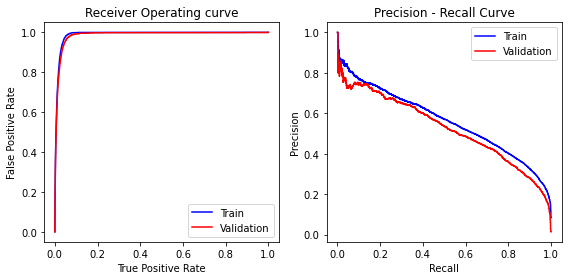

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve
fig,ax = plt.subplots(1,2, figsize = (8,4), tight_layout=True)

tpr, fpr, thresh = roc_curve(train_purchase[:,1], train_predict_proba)
ax[0].plot(tpr,fpr,c='blue')

tpr, fpr, thresh = roc_curve(valid_purchase[:,1], valid_predict_proba)
ax[0].plot(tpr,fpr,c='red')

ax[0].set_title('Receiver Operating curve')
ax[0].set_xlabel('True Positive Rate')
ax[0].set_ylabel('False Positive Rate')
ax[0].legend(labels=['Train','Validation'],loc='lower right')

p,r,t = precision_recall_curve(train_purchase[:,1], train_predict_proba)
ax[1].plot(r,p,c='blue')
p,r,t = precision_recall_curve(valid_purchase[:,1], valid_predict_proba)
ax[1].plot(r,p,c='red')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision - Recall Curve')
ax[1].legend(labels=['Train','Validation'])
plt.show()



These features are pretty good at predicting if there was a purchase, but I didn't take the final pre-processing steps that I normally would for a classification problem (multicollinearity).  Quick check on the test set.

In [27]:
print('Test ROC AUC:', roc_auc_score(test_purchase[:,1], test_predict_proba ))

Test ROC AUC: 0.9840906207313489


The classifier looks useful.  Now I will append the classification probability to the model and re-do the regression.

## Using classifier prediction in regression model
Now how to use the predicted purchase in a regression model.  Is there a way to combine the classification and regression models into one? A model inside a model? For now I will concatenate the classification predicted probabilities to the inputs of the data sets, an create a new regression NN.

In [28]:
train['inputs'].shape

(505867, 288)

In [29]:
X_train = np.hstack([train['inputs'],train_predict_proba.reshape(-1,1)])

X_valid = np.hstack([valid['inputs'],valid_predict_proba.reshape(-1,1)])

X_test = np.hstack([test['inputs'],test_predict_proba.reshape(-1,1)])
print(X_train.shape)

(505867, 289)


Now going back to a tf regression modelling

In [30]:
input_size = X_train.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [31]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))




model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=X_train,
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid,valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 2s - loss: 3.2000 - root_mean_squared_error: 1.7889 - mean_absolute_error: 0.4221 - val_loss: 2.7447 - val_root_mean_squared_error: 1.6567 - val_mean_absolute_error: 0.3360
Epoch 2/50
1012/1012 - 2s - loss: 2.8713 - root_mean_squared_error: 1.6945 - mean_absolute_error: 0.3541 - val_loss: 2.7367 - val_root_mean_squared_error: 1.6543 - val_mean_absolute_error: 0.3061
Epoch 3/50
1012/1012 - 3s - loss: 2.8141 - root_mean_squared_error: 1.6775 - mean_absolute_error: 0.3397 - val_loss: 2.6996 - val_root_mean_squared_error: 1.6431 - val_mean_absolute_error: 0.3217
Epoch 4/50
1012/1012 - 2s - loss: 2.7571 - root_mean_squared_error: 1.6605 - mean_absolute_error: 0.3308 - val_loss: 2.7404 - val_root_mean_squared_error: 1.6554 - val_mean_absolute_error: 0.3046
Epoch 5/50
1012/1012 - 2s - loss: 2.7424 - root_mean_squared_error: 1.6560 - mean_absolute_error: 0.3272 - val_loss: 2.7451 - val_root_mean_squared_error: 1.6568 - val_mean_absolute_error: 0.3174
Epoch 6/50
1012/1012

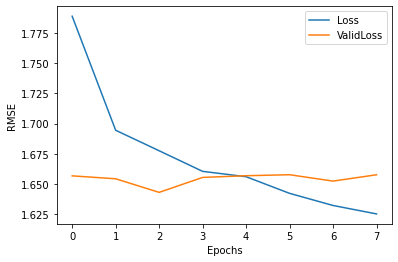

In [33]:
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
PlotLoss(history)

In [34]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train,X_valid, X_test],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
seq_nn_w_clf = pd.DataFrame(perf,index = ['train','validation','test'])
seq_nn_w_clf

2257/2257 [==============================] - 1s 647us/step - loss: 2.7846 - root_mean_squared_error: 1.6687 - mean_absolute_error: 0.3244


,RMSE
train,1.631626
validation,1.643055
test,1.668701


In [35]:
base_seq_nn

,RMSE
train,1.630484
validation,1.639824
test,1.662625


There was only a very small improvement in using the classifier prediction for the regression model for the validation and test sets.  The training set has decreased more, but it looks to be overfitting to the training set, not really an improvement.

### Expected revenue
Next I'll try multiplying the regression prediction by the classification probability, a sort of expected purchase for each user. There is a Multiply layer so maybe I can pass the classifier probabilities to the regression model.  For now I will simply take the classifier probabilities multiplied by the regression output.

In [36]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50

In [37]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))





model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [38]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 2s - loss: 3.2700 - root_mean_squared_error: 1.8083 - mean_absolute_error: 0.4317 - val_loss: 2.7657 - val_root_mean_squared_error: 1.6630 - val_mean_absolute_error: 0.3454
Epoch 2/50
1012/1012 - 2s - loss: 2.9201 - root_mean_squared_error: 1.7088 - mean_absolute_error: 0.3675 - val_loss: 2.7902 - val_root_mean_squared_error: 1.6704 - val_mean_absolute_error: 0.3164
Epoch 3/50
1012/1012 - 2s - loss: 2.8452 - root_mean_squared_error: 1.6868 - mean_absolute_error: 0.3542 - val_loss: 2.8175 - val_root_mean_squared_error: 1.6785 - val_mean_absolute_error: 0.3032
Epoch 4/50
1012/1012 - 2s - loss: 2.8003 - root_mean_squared_error: 1.6734 - mean_absolute_error: 0.3490 - val_loss: 2.7466 - val_root_mean_squared_error: 1.6573 - val_mean_absolute_error: 0.3220
Epoch 5/50
1012/1012 - 2s - loss: 2.7764 - root_mean_squared_error: 1.6663 - mean_absolute_error: 0.3413 - val_loss: 2.8333 - val_root_mean_squared_error: 1.6832 - val_mean_absolute_error: 0.3295
Epoch 6/50
1012/1012

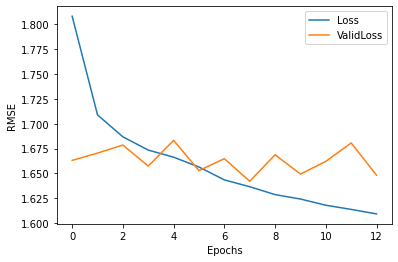

In [39]:
PlotLoss(history)

In [40]:
train_predict_exp = model.predict(train['inputs']) * train_predict_proba.reshape(1,-1).T

valid_predict_exp = model.predict(valid['inputs']) * valid_predict_proba.reshape(1,-1).T

test_predict_exp = model.predict(test['inputs']) * test_predict_proba.reshape(1,-1).T

In [41]:
print('Train RMSE:',np.sqrt(mean_squared_error(train['targets'],train_predict_exp)))
print('Validation RMSE:',np.sqrt(mean_squared_error(valid['targets'],valid_predict_exp)))
print('Test RMSE:',np.sqrt(mean_squared_error(test['targets'],test_predict_exp)))

Train RMSE: 1.8014756699506407
Validation RMSE: 1.795658177369295
Test RMSE: 1.811279527795445


These numbers are worse, and of course they are the model is solved for by minimizing the MSE and then I multiplied the output by some scalar it hasn't seen before.  I need to figure out how to add the multiplication of the purchase probability as the last layer in the tf model.

### Now using Keras' Functional API I will attempt a network of layers to create a regressor and classifier in 1 model
I will do this 2 ways:
- the classifier as a probability multiplied by the regression output
- the classifier as an input into the regression

The model will use the same inputs, and have two ouputs, a classifier for a purchase and a regressor for the size of the purchase. The model will optimize for both at the same time.

In [43]:
#import tensorflow as tf
#import pandas as pd
#import matplotlib.pyplot as plt

In [42]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 100

In [43]:
### Creation of classifier targets (already have regrssion targets)
train_purchase = 1.0 * np.array( [train['targets'] == 0, train['targets']>0] ).T
valid_purchase = 1.0 * np.array( [valid['targets'] ==0 , valid['targets'] > 0] ).T
test_purchase = 1.0 * np.array( [test['targets'] ==0 , test['targets'] > 0] ).T

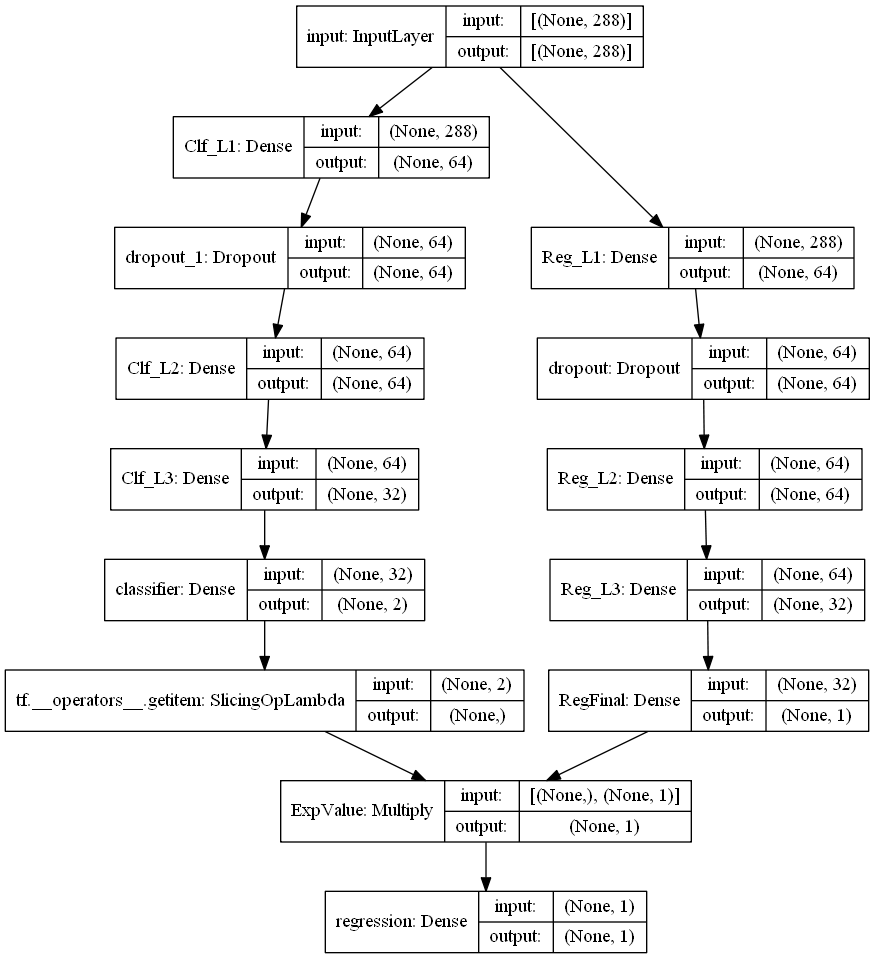

In [44]:
tf.keras.backend.clear_session()
### Create input layer
inputs = tf.keras.Input(shape=(input_size,),name='input') # shape (features,)

### Now build regression portion of model
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L1')(inputs) # shape (None, 64)
reg = tf.keras.layers.Dropout(.2)(reg)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L2')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(hidden_layer_size//2, activation='relu', name='Reg_L3')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(1, name='RegFinal')(reg) # shape (None,1)


### Building the classifier
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L1')(inputs) # shape (None, 64)
clf = tf.keras.layers.Dropout(.2)(clf)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L2')(clf) # shape (None, 64)
clf = tf.keras.layers.Dense(hidden_layer_size//2, activation = 'relu', name='Clf_L3')(clf) # shape (None, 64)
clf_out = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(clf) # shape (None, 2)

### Final step, multiply purchase prediction by regression prediction
reg_out = tf.keras.layers.multiply([clf_out[:,1], reg], name='ExpValue')
reg_out = tf.keras.layers.Dense(output_size, name='regression')(reg_out)

complex_model = tf.keras.Model(inputs=inputs, outputs = [reg_out, clf_out])

tf.keras.utils.plot_model(complex_model, show_shapes=True)

#complex_model.summary()


In [45]:
complex_model.compile(optimizer='adam',
                     loss={'classifier':tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          'regression': tf.keras.losses.MeanSquaredError()},
                     metrics={'classifier':[tf.keras.metrics.AUC(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.Recall()],
                             'regression': [tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.MeanAbsoluteError()]}
                     )

In [46]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = complex_model.fit(train['inputs'],
                           {'regression':train['targets'],'classifier':train_purchase},
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=earlystop,
                           validation_data=(valid['inputs'],{'regression':valid['targets'],
                                                              'classifier':valid_purchase}),
                           verbose=2
                           )

Epoch 1/100
1012/1012 - 7s - loss: 3.3027 - regression_loss: 3.2376 - classifier_loss: 0.0651 - regression_root_mean_squared_error: 1.7993 - regression_mean_absolute_error: 0.3561 - classifier_auc: 0.9979 - classifier_precision: 0.9831 - classifier_recall: 0.9831 - val_loss: 2.8671 - val_regression_loss: 2.8169 - val_classifier_loss: 0.0502 - val_regression_root_mean_squared_error: 1.6784 - val_regression_mean_absolute_error: 0.3525 - val_classifier_auc: 0.9988 - val_classifier_precision: 0.9805 - val_classifier_recall: 0.9805
Epoch 2/100
1012/1012 - 4s - loss: 2.9887 - regression_loss: 2.9448 - classifier_loss: 0.0439 - regression_root_mean_squared_error: 1.7160 - regression_mean_absolute_error: 0.3308 - classifier_auc: 0.9986 - classifier_precision: 0.9842 - classifier_recall: 0.9842 - val_loss: 2.9007 - val_regression_loss: 2.8530 - val_classifier_loss: 0.0477 - val_regression_root_mean_squared_error: 1.6891 - val_regression_mean_absolute_error: 0.3483 - val_classifier_auc: 0.9989 -

In [47]:
complex_model.metrics_names

['loss',
 'regression_loss',
 'classifier_loss',
 'regression_root_mean_squared_error',
 'regression_mean_absolute_error',
 'classifier_auc',
 'classifier_precision',
 'classifier_recall']

In [48]:
history.history.keys()

dict_keys(['loss', 'regression_loss', 'classifier_loss', 'regression_root_mean_squared_error', 'regression_mean_absolute_error', 'classifier_auc', 'classifier_precision', 'classifier_recall', 'val_loss', 'val_regression_loss', 'val_classifier_loss', 'val_regression_root_mean_squared_error', 'val_regression_mean_absolute_error', 'val_classifier_auc', 'val_classifier_precision', 'val_classifier_recall'])

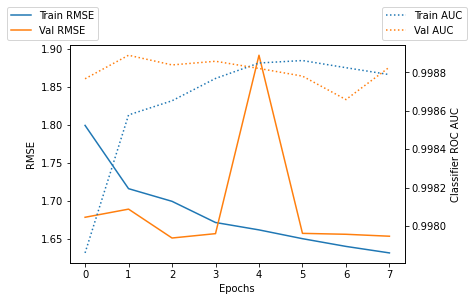

In [49]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(history.history['regression_root_mean_squared_error'] ,label='Train RMSE')
ax.plot(history.history['val_regression_root_mean_squared_error'] ,label='Val RMSE')

ax2 = ax.twinx()

ax2.plot(history.history['classifier_auc'],label='Train AUC', linestyle=':')
ax2.plot(history.history['val_classifier_auc'],label = 'Val AUC', linestyle=':')

ax.set_xlabel('Epochs')

ax.set_ylabel('RMSE')
ax2.set_ylabel('Classifier ROC AUC')
ax2.legend(bbox_to_anchor= (1.2, 1.2))
ax.legend(bbox_to_anchor= (0.1, 1.2))
#ax2.legend(loc='upper', bbox_to_anchor= (1.1, 0.6), ncol=1,
 #           borderaxespad=0, frameon=False)
#plt.legend(loc='upper right')
plt.show()

### Performance


In [50]:
metrics = complex_model.metrics_names
metrics

['loss',
 'regression_loss',
 'classifier_loss',
 'regression_root_mean_squared_error',
 'regression_mean_absolute_error',
 'classifier_auc',
 'classifier_precision',
 'classifier_recall']

In [51]:
perf = {k:[] for k in ['RMSE', 'ROC AUC', 'Recall']}
for inputs, r_targets,c_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']],
                                             [train_purchase, valid_purchase, test_purchase]):
    
    dum = complex_model.evaluate(inputs,{'regression':r_targets,'classifier':c_targets})
    perf['RMSE'].append(dum[metrics.index('regression_root_mean_squared_error')])
    perf['ROC AUC'].append(dum[metrics.index('classifier_auc')])
    perf['Recall'].append(dum[metrics.index('classifier_recall')])
    del dum
complex_nn_exp = pd.DataFrame(perf,index = ['train','validation','test'])
complex_nn_exp
    

2257/2257 [==============================] - 2s 1ms/step - loss: 2.8466 - regression_loss: 2.8078 - classifier_loss: 0.0388 - regression_root_mean_squared_error: 1.6757 - regression_mean_absolute_error: 0.3145 - classifier_auc: 0.9987 - classifier_precision: 0.9840 - classifier_recall: 0.9840


,RMSE,ROC AUC,Recall
train,1.637403,0.998867,0.984899
validation,1.651069,0.998838,0.984565
test,1.675658,0.998660,0.983974


In [52]:
base_seq_nn

,RMSE
train,1.630484
validation,1.639824
test,1.662625


In [53]:
seq_nn_w_clf

,RMSE
train,1.631626
validation,1.643055
test,1.668701


This NN is doesn't have any additoinal predictive power on the validation and test sets, and it is more over fit to the training data.   Not an improvement.

### Complex model 2
Using classifier output as input into regression

In [54]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 100
epochs = 100

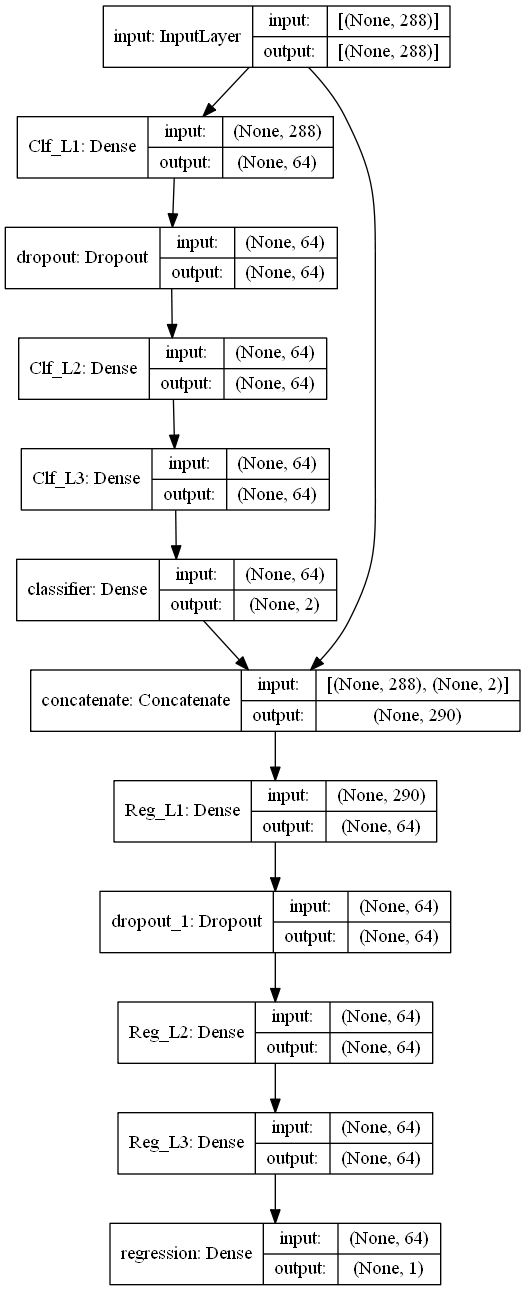

In [55]:
tf.keras.backend.clear_session()
### Create input layer
inputs = tf.keras.Input(shape=(input_size,),name='input') # shape (features,)

### Building the classifier
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L1')(inputs) # shape (None, 64)
clf = tf.keras.layers.Dropout(.2)(clf)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L2')(clf) # shape (None, 64)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L3')(clf) # shape (None, 64)
clf_out = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(clf) # shape (None, 2)

### Now build regression portion of model
reg = tf.keras.layers.concatenate([inputs, clf_out],axis=1) # shape (features + 1, )

reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L1')(reg) # shape (None, 64)
reg = tf.keras.layers.Dropout(.2)(reg)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L2')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L3')(reg) # shape (None, 64)
reg_out = tf.keras.layers.Dense(1, name='regression')(reg) # shape (None,1)


complex_model = tf.keras.Model(inputs=inputs, outputs = [reg_out, clf_out])

tf.keras.utils.plot_model(complex_model, show_shapes=True)

#complex_model.summary()


In [56]:
complex_model.compile(optimizer='adam',
                     loss={'classifier':tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          'regression': tf.keras.losses.MeanSquaredError()},
                     metrics={'classifier':[tf.keras.metrics.AUC(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.Recall()],
                             'regression': [tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.MeanAbsoluteError()]}
                     )

In [57]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = complex_model.fit(train['inputs'],
                           {'regression':train['targets'],'classifier':train_purchase},
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=earlystop,
                           validation_data=(valid['inputs'],{'regression':valid['targets'],
                                                              'classifier':valid_purchase}),
                           verbose=2
                           )

Epoch 1/100
5059/5059 - 14s - loss: 3.1773 - regression_loss: 3.1336 - classifier_loss: 0.0437 - regression_root_mean_squared_error: 1.7702 - regression_mean_absolute_error: 0.3860 - classifier_auc: 0.9963 - classifier_precision: 0.9849 - classifier_recall: 0.9849 - val_loss: 2.9095 - val_regression_loss: 2.8757 - val_classifier_loss: 0.0338 - val_regression_root_mean_squared_error: 1.6958 - val_regression_mean_absolute_error: 0.3176 - val_classifier_auc: 0.9974 - val_classifier_precision: 0.9870 - val_classifier_recall: 0.9870
Epoch 2/100
5059/5059 - 13s - loss: 2.9374 - regression_loss: 2.9001 - classifier_loss: 0.0373 - regression_root_mean_squared_error: 1.7030 - regression_mean_absolute_error: 0.3407 - classifier_auc: 0.9967 - classifier_precision: 0.9867 - classifier_recall: 0.9867 - val_loss: 2.9708 - val_regression_loss: 2.9370 - val_classifier_loss: 0.0338 - val_regression_root_mean_squared_error: 1.7138 - val_regression_mean_absolute_error: 0.3027 - val_classifier_auc: 0.9974

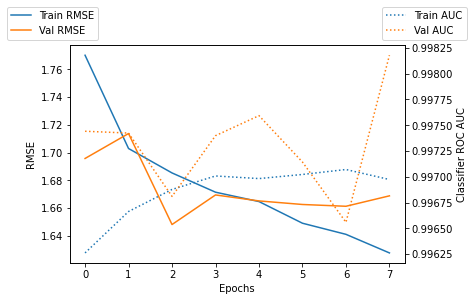

In [58]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(history.history['regression_root_mean_squared_error'] ,label='Train RMSE')
ax.plot(history.history['val_regression_root_mean_squared_error'] ,label='Val RMSE')

ax2 = ax.twinx()

ax2.plot(history.history['classifier_auc'],label='Train AUC', linestyle=':')
ax2.plot(history.history['val_classifier_auc'],label = 'Val AUC', linestyle=':')

ax.set_xlabel('Epochs')

ax.set_ylabel('RMSE')
ax2.set_ylabel('Classifier ROC AUC')
ax2.legend(bbox_to_anchor= (1.2, 1.2))
ax.legend(bbox_to_anchor= (0.1, 1.2))
#ax2.legend(loc='upper', bbox_to_anchor= (1.1, 0.6), ncol=1,
 #           borderaxespad=0, frameon=False)
#plt.legend(loc='upper right')
plt.show()

In [59]:
perf = {k:[] for k in ['RMSE', 'ROC AUC', 'Recall']}
for inputs, r_targets,c_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']],
                                             [train_purchase, valid_purchase, test_purchase]):
    
    dum = complex_model.evaluate(inputs,{'regression':r_targets,'classifier':c_targets})
    perf['RMSE'].append(dum[metrics.index('regression_root_mean_squared_error')])
    perf['ROC AUC'].append(dum[metrics.index('classifier_auc')])
    perf['Recall'].append(dum[metrics.index('classifier_recall')])
    del dum
pd.DataFrame(perf,index = ['train','validation','test'])
    

2257/2257 [==============================] - 3s 1ms/step - loss: 2.8368 - regression_loss: 2.8016 - classifier_loss: 0.0352 - regression_root_mean_squared_error: 1.6738 - regression_mean_absolute_error: 0.3248 - classifier_auc: 0.9964 - classifier_precision: 0.9870 - classifier_recall: 0.9870


,RMSE,ROC AUC,Recall
train,1.640452,0.996728,0.987773
validation,1.648162,0.996810,0.987711
test,1.673799,0.996435,0.987049


In [60]:
### base case 3 layer NN
base_seq_nn

,RMSE
train,1.630484
validation,1.639824
test,1.662625


In [61]:
### Sequential NN with classifier added to features
seq_nn_w_clf

,RMSE
train,1.631626
validation,1.643055
test,1.668701


In [62]:
### Complex NN model 1
complex_nn_exp

,RMSE,ROC AUC,Recall
train,1.637403,0.998867,0.984899
validation,1.651069,0.998838,0.984565
test,1.675658,0.998660,0.983974


This model produced a test RMSE that is a tiny bit higher than the two sequential models, and it appears to be overfit to the same degree as the other models.  I will proceed with the standard sequential NN. 

In [129]:
#tf.keras.backend.clear_session()

In [3]:
import tensorflow as tf

In [4]:
### Declare some variables for modelling 

input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


Model building

In [5]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 2s - loss: 3.2925 - root_mean_squared_error: 1.8145 - mean_absolute_error: 0.4367 - val_loss: 2.8525 - val_root_mean_squared_error: 1.6889 - val_mean_absolute_error: 0.3464
Epoch 2/50
1012/1012 - 2s - loss: 2.9171 - root_mean_squared_error: 1.7079 - mean_absolute_error: 0.3715 - val_loss: 2.7343 - val_root_mean_squared_error: 1.6536 - val_mean_absolute_error: 0.3365
Epoch 3/50
1012/1012 - 3s - loss: 2.8353 - root_mean_squared_error: 1.6838 - mean_absolute_error: 0.3556 - val_loss: 2.7522 - val_root_mean_squared_error: 1.6590 - val_mean_absolute_error: 0.3278
Epoch 4/50
1012/1012 - 3s - loss: 2.8038 - root_mean_squared_error: 1.6744 - mean_absolute_error: 0.3455 - val_loss: 2.7244 - val_root_mean_squared_error: 1.6506 - val_mean_absolute_error: 0.3273
Epoch 5/50
1012/1012 - 2s - loss: 2.7599 - root_mean_squared_error: 1.6613 - mean_absolute_error: 0.3374 - val_loss: 2.7200 - val_root_mean_squared_error: 1.6492 - val_mean_absolute_error: 0.3369
Epoch 6/50
1012/1012

In [7]:
import matplotlib.pyplot as plt
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    

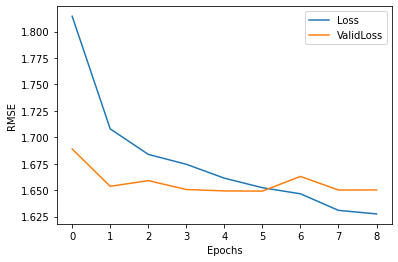

In [8]:
PlotLoss(history)

In [9]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
base_seq_nn = pd.DataFrame(perf,index = ['train','validation','test'])
base_seq_nn

2257/2257 [==============================] - 2s 716us/step - loss: 2.7428 - root_mean_squared_error: 1.6561 - mean_absolute_error: 0.3173


,RMSE
train,1.605914
validation,1.649069
test,1.656126


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                18496     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 26,881
Trainable params: 26,881
Non-trainable params: 0
_________________________________________________________________


### Final Model
Above is the final model and the RMSE scores for the train, validation and test sets.  Reducing the features through VIF reduced the overfitting of the model but did come at the cost of increasing RMSE for validation and test sets.  


In [11]:
model.save(r'C:\Users\blain\GitHub\Capstone_GA-Revenue-Prediction\final_nn_model_user_revenue')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

Now to help the marketing team I will use the `shap` library to explain the model and it's features. 

In [12]:
### Load feature labels
with open('All features.txt','r') as f:
    alllabels = f.read().split('\n')

with open('vif output.txt','r') as f:
    vif_out = f.read().split('\n')
vif_out = [i for i in vif_out if i.startswith('Removing')]
import re
vif_dropped = []
for i in vif_out:
    vif_dropped.append(re.search('ing (.*?) with',i).group(1))

model_feats = list(set(alllabels) - set(vif_dropped))
print(len(model_feats))

288


In [13]:
import shap
shap.initjs()

To reduce computation time I will extract a small number of samples from the training set (for background) and the test set (for shap_value calculation).  I will do a 'somewhat balnaced' sampling to ensure that there are non-zero revenue users in each set. 

In [14]:
### Create subset of background for shap calculation 

nonpurchasers = 40
purchasers = 10

nonp = np.array(np.where(train['targets']==0.0)).reshape(-1,)
nonp_samps = np.random.choice(nonp,size = nonpurchasers)

purch = np.array(np.where(train['targets']>0)).reshape(-1,)
purch_samps = np.random.choice(purch, size = purchasers)

background_rand_samples = np.concatenate([nonp_samps,purch_samps])
del  nonp, nonp_samps, purch, purch_samps

background = train['inputs'][background_rand_samples,:]

background = pd.DataFrame(background,columns=model_feats)

background.shape


(50, 288)

In [15]:
### Create subset for shap pertrubations 
nonpurchasers = 400
purchasers = 100

nonp = np.array(np.where(valid['targets']==0.0)).reshape(-1,)
nonp_samps = np.random.choice(nonp,size = nonpurchasers)

purch = np.array(np.where(valid['targets']>0)).reshape(-1,)
purch_samps = np.random.choice(purch, size = purchasers)

shap_random_samples = np.concatenate([nonp_samps,purch_samps])
del  nonp, nonp_samps, purch, purch_samps

shapdata = valid['inputs'][shap_random_samples,:]


shapdata = pd.DataFrame(shapdata,columns=model_feats)

shapdata.shape

(500, 288)

In [16]:
explainer = shap.explainers.Permutation(model.predict, background)

In [17]:
shap_values = explainer(shapdata)

Permutation explainer: 501it [21:24,  2.58s/it]                         


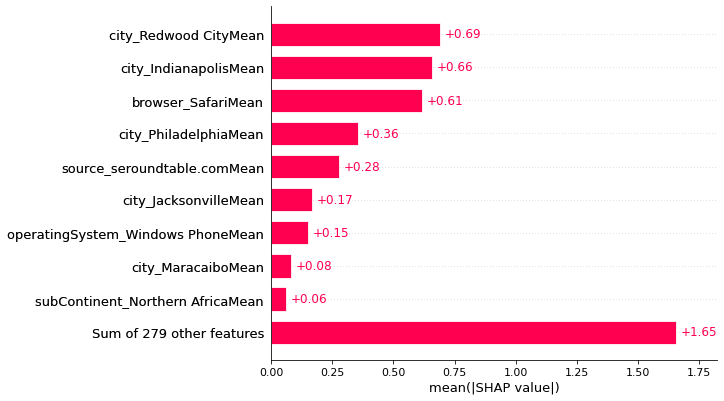

In [20]:
shap.plots.bar(shap_values,max_display=10)


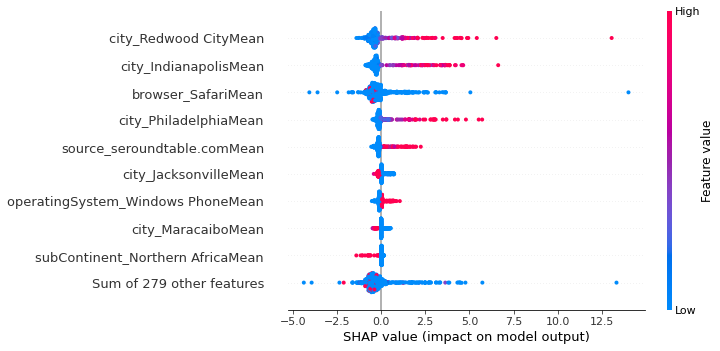

In [21]:
shap.plots.beeswarm(shap_values, max_display=10)

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np
mean_train = np.mean(train['targets'])

test_target_mean = np.zeros(test['targets'].shape)
test_target_mean = test_target_mean + mean_train
test_target_mean[:3]


array([0.25210859, 0.25210859, 0.25210859])

In [18]:
rmse = np.sqrt(mean_squared_error(test['targets'],test_target_mean))
print(f'RMSE for mean of training set:\n{rmse:.5f}')

RMSE for mean of training set:
2.08267


In [ ]:
print(f'RMSE for mean  ')